In [97]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.nn.functional as F

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [98]:
path = 'lfw'

In [99]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)
images, _ = next(iter(dataloader))

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [86]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


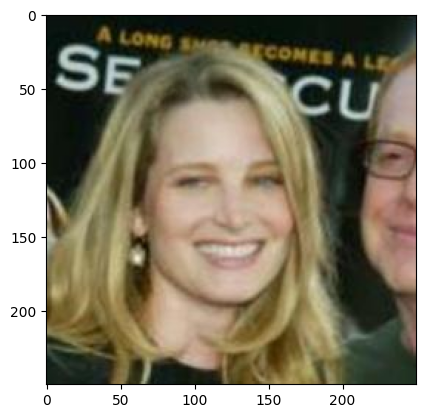

In [87]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

AutoEncoders (AEs) and Variational AutoEncoders (VAEs) are both neural network architectures used for different purposes and have significant differences:

1. **Applications**:
   - **AutoEncoders**: AEs are primarily used for tasks where the accurate representation of input data is crucial. They excel in applications such as data compression, noise reduction, and feature extraction. AEs aim to encode input data into a lower-dimensional latent space while preserving as much information as possible.
   - **Variational AutoEncoders (VAEs)**: VAEs are employed in more creative and generative applications. They are designed to synthesize new data samples that resemble their training datasets. VAEs are commonly used in tasks like image generation, music composition, and text generation. They not only capture meaningful features from the data but also introduce an element of randomness to generate diverse and plausible new data points.

2. **Architecture**:
   - **AutoEncoders**: AEs have a relatively straightforward architecture consisting of an encoder and a decoder. The encoder maps input data to a fixed-size latent space representation, and the decoder maps the latent space back to the original data space.
   - **Variational AutoEncoders (VAEs)**: VAEs introduce complexity by encoding input data into a probabilistic distribution described by mean (μ) and variance (σ^2). This distribution in the latent space allows VAEs to sample from it, introducing randomness into the generation process. This randomness is essential for the generation of diverse data samples.

3. **Loss Function**:
   - **AutoEncoders**: AEs primarily use as loss function that measures the difference between the input and the output. Common loss functions include Mean Squared Error (MSE) or Binary Cross-Entropy, depending on the type of data.
   - **Variational AutoEncoders (VAEs)**: VAEs employ a dual-component loss function. The first component is similar to AEs, focusing on data reconstruction accuracy. This component ensures that the generated data resembles the input data. The second component is the Kullback-Leibler (KL) divergence term, which acts as a regularizer. It measures how the encoded distribution in the latent space deviates from a prior distribution, typically a standard Gaussian distribution. The KL divergence encourages the latent space to have desirable properties, such as continuity and completeness, making it suitable for generating new data points.

In summary, while both AEs and VAEs involve encoding and decoding data, VAEs introduce probabilistic elements and a more complex loss function. These additions make VAEs well-suited for generative tasks and learning meaningful representations with the ability to generate new, diverse data samples.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [104]:
import torch
from torch import nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        input_val = 3
        width = 250
        height = 250
        levels = 512
        layers = 20
        # Encoder
        self.fc1 = nn.Linear(input_val * width * height, levels)  
        self.fc21 = nn.Linear(levels, layers)  
        self.fc22 = nn.Linear(levels, layers) 

        # Decoder
        self.fc3 = nn.Linear(layers, levels)
        self.fc4 = nn.Linear(levels, height * width * input_val)  

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Create an instance of the VAE class
model = VAE().to(device)

# Print the model's architecture
print(model)


VAE(
  (fc1): Linear(in_features=187500, out_features=512, bias=True)
  (fc21): Linear(in_features=512, out_features=20, bias=True)
  (fc22): Linear(in_features=512, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=187500, bias=True)
)


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [105]:
# Created an instance of the VAE class

sample_image = images[0].unsqueeze(0)  # Process one image

# Encoded the sample image to the latent space
encoded, _ = model.encode(sample_image)
print("Encoded output shape after encoding:", encoded.shape)

# Generated a new sample in the latent space (randomly)
with torch.no_grad():
    random_sample = torch.randn(1, 20)  # 1 sample with 20 dimensions (adjust as needed)
    print("Random sample from latent space shape:", random_sample.shape)
    generated_image = model.decode(random_sample)


Encoded output shape after encoding: torch.Size([1, 20])
Random sample from latent space shape: torch.Size([1, 20])


In [106]:
z = model.reparameterize(*model.encode(sample_image))
decoded_images = model.decode(z)
print("Decoded images shape:", decoded_images.shape)

# Print the shape of the generated image
print("Generated image shape after decoding:", generated_image.shape)


Decoded images shape: torch.Size([1, 187500])
Generated image shape after decoding: torch.Size([1, 187500])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

while training a Variational Autoencoder (VAE), the loss function that is typically used is a combination of two terms: the Reconstruction Loss and the Kullback-Leibler (KL) Divergence Loss. These two serve different purposes in training a VAE:

1. **Reconstruction Loss**:
   - The Reconstruction Loss measures how better the generated output (reconstructed_x) matches with the original input (original_x). It quantifies the difference between what the VAE generates and the actual data from the dataset.
   - In the code, the reconstruction loss is computed using the binary cross-entropy loss (F.binary_cross_entropy). This loss function is suitable for comparing pixel-wise values between the generated and original images.
   - The goal of the Reconstruction Loss is to ensure that the VAE learns to generate data that is as close as possible to the input data. Minimizing this loss term encourages the VAE to generate images that are faithful reproductions of the input images.

2. **Kullback-Leibler (KL) Divergence Loss**:
   - The KL Divergence Loss is a regularization term in the VAE that encourages the distribution of latent variables (mu and logvar) to be as close as possible to a predefined prior distribution, typically a standard Gaussian distribution.
   - In the code, the KL Divergence Loss is calculated using the formula -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()). This term measures the dissimilarity between the learned distribution (defined by mu and logvar) and the desired Gaussian distribution.
   - The goal of the KL Divergence Loss is to ensure that the latent space of the VAE has desirable properties, such as continuity and completeness, which are important for generating new data samples. It prevents the latent space from collapsing into a single point by introducing a form of regularization.
   
Overall, the total loss function for the VAE is a combination of these two terms, and its purpose is to strike a balance between generating high-quality data samples (Reconstruction Loss) and maintaining a well-structured latent space (KL Divergence Loss). By optimizing this loss, the VAE learns to both faithfully reconstruct input data and generate new data samples from a meaningful and structured latent space.

In [107]:
import torch
import torch.optim as optim  

# Calculate the total number of trainable parameters
total_params = 0
for p in model.parameters():
    if p.requires_grad:
        total_params += p.numel()
print("Total number of trainable parameters:", total_params)

def vae_loss(reconstructed_x, original_x, mu, logvar):
    # Flatten the original_x to match the size of reconstructed_x
    original_x = original_x.view(reconstructed_x.size())
    # Reconstruction Loss
    binary_cross_entropy_loss = F.binary_cross_entropy(reconstructed_x, original_x, reduction='sum')
    # Kullback-Leibler Divergence
    kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return binary_cross_entropy_loss + kl_divergence_loss


# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Total number of trainable parameters: 192219284


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

#### Techniques for Troubleshooting when loss is not decreasing
1. **Check Data Preprocessing**: Making sure that data preprocessing is correct. Data should be normalized, and any necessary transformations should be applied. Also, check that your data loader is shuffling the data appropriately and that the data is being loaded correctly.However in our scenario data is images.

2. **Check Hyperparameters**: Verifying that learning rate, batch size, and the number of epochs are appropriate for the dataset and model architecture. If the learning rate is too high, it can cause the loss to diverge.

3. **Check Model Architecture**: Making sure that VAE architecture is correctly implemented. Checking the dimensions of convulation layers and the latent space size. If network is too shallow or too deep, it can affect training. We should make sure that we have the correct activation functions and layer types.

4. **Check Loss Function**: Double check your VAE loss function. Ensure it combines the reconstruction loss and the KL-divergence loss correctly. Any errors in the loss function can lead to issues in training and it can affect model performance.

5. **Gradient Clipping**: Sometimes, gradient explosion can cause the loss to blow up. we can add gradient clipping to limit the gradients during backpropagation. We can do this after setting a maximum gradient value.

```python
torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
```

6. **Monitoring Latent Space**: If VAE is not learning a meaningful latent space, it can affect the reconstruction loss and overall training. You can monitor the latent space by visualizing it. Plotting samples from the latent space and see if they make more sense. If not, consider adjusting the architecture or latent space dimension.

7. **Regularization**: We can try adding additional regularization techniques such as weight decay or dropout layers to your model to improve training stability.

8. **Debugging**: Use print statements or debugging tools to check intermediate values during training, especially within the loss function, to identify any unexpected behavior.

9. **Increase Complexity**: If the model is too simple, it may struggle to capture the complexity of data. Consider increasing the model's complexity by adding more layers or units.

10. **Data Augmentation**: If we have a small dataset, consider applying data augmentation techniques to increase the effective size of your training dataset.

11. **Learning Rate Scheduling**: Implement learning rate scheduling, where we can gradually reduce learning rate during training. This can help model converge more effectively.

12. **Changing Optimizer**: Experiment with different optimizers (e.g., Adam, RMSProp) to see if they perform better on the specific problem.

In [ ]:
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

epochs = 10  # Number of training epochs
batch_size = 64  # Batch size
log_interval = 100  # Log interval for displaying loss

# Function for training the VAE model
def train_model(model, dataloader, optimizer, loss_function, epochs=10):
    model.train()  # Setting the model to training mode
    for epoch in range(1, epochs + 1):
        total_loss = 0.0  # Initialized the total loss for this epoch
        for batch_idx, (data, _) in enumerate(dataloader):
            optimizer.zero_grad()  # Zero the gradients
            data = data.to(device)  # Move the data to your device (CPU or GPU)

            # Forward pass: Compute the VAE loss
            reconstructed_x, mu, logvar = model(data)
            loss = loss_function(reconstructed_x, data, mu, logvar)

            # Backward pass: Compute gradients and update model weights
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % log_interval == 0:
                print(f'Epoch [{epoch}/{epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}')

        # Calculating and printing the average loss for this epoch
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}')

# Train the VAE model
train_model(model, dataloader, optimizer, vae_loss, epochs=epochs)


Epoch [1/10], Batch [0/414], Loss: 4203261.0000
Epoch [1/10], Batch [100/414], Loss: 4204836.5000
Epoch [1/10], Batch [200/414], Loss: 4207122.0000
Epoch [1/10], Batch [300/414], Loss: 4204596.0000
Epoch [1/10], Batch [400/414], Loss: 4205680.5000
Epoch [1/10], Average Loss: 4200931.2494
Epoch [2/10], Batch [0/414], Loss: 4204449.5000
Epoch [2/10], Batch [100/414], Loss: 4202551.0000
Epoch [2/10], Batch [200/414], Loss: 4202359.5000
Epoch [2/10], Batch [300/414], Loss: 4204506.0000
Epoch [2/10], Batch [400/414], Loss: 4206487.5000
Epoch [2/10], Average Loss: 4201091.1178
Epoch [3/10], Batch [0/414], Loss: 4204299.0000
Epoch [3/10], Batch [100/414], Loss: 4202015.0000
Epoch [3/10], Batch [200/414], Loss: 4198992.0000
Epoch [3/10], Batch [300/414], Loss: 4201890.0000
Epoch [3/10], Batch [400/414], Loss: 4211652.0000
Epoch [3/10], Average Loss: 4200884.9601
Epoch [4/10], Batch [0/414], Loss: 4205702.5000
Epoch [4/10], Batch [100/414], Loss: 4205658.0000
Epoch [4/10], Batch [200/414], Loss

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

**Generating and Comparing Images**

In this section, we will generate a new image sample from the VAE's latent space and compare it with a random image from the dataset.


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'images' is a batch from your dataloader
sample_image = images[0].unsqueeze(0)  # Process one image
# Encode the sample image to the latent space
encoded, _ = model.encode(sample_image)

# Generate a new sample in the latent space (randomly)
with torch.no_grad():
    random_sample = torch.randn(1, 20)  # 1 sample with 20 dimensions (adjust as needed)
    generated_image = model.decode(random_sample)

# Convert tensors to numpy arrays for visualization
sample_image = sample_image.squeeze().cpu().numpy()
generated_image = generated_image.squeeze().cpu().numpy()

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axs[0].imshow(sample_image.transpose(1, 2, 0))
axs[0].set_title('Original Image')

# Reshape and plot the generated image to match the shape of the original image
generated_image = generated_image.reshape(sample_image.shape)  # Reshape to match the shape
axs[1].imshow(generated_image.transpose(1, 2, 0))
axs[1].set_title('Generated Image')

# Remove axis labels and display the plot
for ax in axs:
    ax.axis('off')

plt.show()
